<a href="https://colab.research.google.com/github/Faiz-fs/aspect-based-feature-selection-sentiment-analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install scikit-learn

In [2]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:
import pandas as pd
import torch
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings

In [4]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flipkart-cell-phone-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2319008%2F3904140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240419%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240419T141804Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D16dc5ec36df2db83b4c2e68f74c8f13f2d65263745b2cb856de0e023ba656e611319368da4e3eea94999692731c8dc081a587033792e616cc6d19ee2896b317d5031a6763d9e537dc069e145ebe8904967312b8fbe7d4cbb482a556fab4566999854642e686a88535116a31c8e8a3bc27c4637bedd50b2e494a392d4216ee7162ba6b864ef8a137a149c89a7e46df28cc112347009cd8aa36014a7cf66f462725a6530b26465ecc49d0ed19e6b7bcbf44f6c139eb8c225afab8f8c412c2dd86e559be82fb116c23c4e512dcd69ec881991880bd5100bfc9e05fca21fa56d9f0ed10eccd6eab4f2ee0f6d56c7051baff5d13788701bc7c61d2d7af6f335976e90'

KAGGLE_INPUT_PATH='/content/dataset'
KAGGLE_WORKING_PATH='/content/dataset'
KAGGLE_SYMLINK='content'

!umount /content/dataset 2> /dev/null
shutil.rmtree('/content/dataset', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 2914398 bytes downloaded
Downloaded and uncompressed: flipkart-cell-phone-reviews
Data source import complete.


In [5]:
con = sqlite3.connect("/content/dataset/flipkart-cell-phone-reviews/flipkart_products.db")
items = pd.read_sql_query("SELECT * from items", con)
con.close()

In [6]:
items.head()

,product_id,product_name,price,category,sub_category,specifications,ratings,discount,moreinfo
0,ECMB000001,"Redmi 9A (SeaBlue, 32 GB)","₹7,413",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-seablue-32-gb/p/itmeabd39a0cd669?pid...
1,ECMB000002,"Redmi 9A (Midnight Black, 32 GB)","₹7,421",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,3.0,/redmi-9a-midnight-black-32-gb/p/itmeabd39a0cd...
2,ECMB000003,"Redmi 9A (Nature Green, 32 GB)","₹7,384",Electronics,Mobile,2 GB RAM | 32 GB ROM16.59 cm (6.53 inch) Full ...,4.3,4.0,/redmi-9a-nature-green-32-gb/p/itmeabd39a0cd66...
3,ECMB000004,"Redmi 9 (Carbon Black, 64 GB)","₹10,745",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-carbon-black-64-gb/p/itm4fb151383983b...
4,ECMB000005,"Redmi 9 (Sky Blue, 64 GB)","₹10,489",Electronics,Mobile,4 GB RAM | 64 GB ROM16.59 cm (6.53 inch) HD+ D...,4.2,None,/redmi-9-sky-blue-64-gb/p/itm4fb151383983b?pid...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('product_id').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('product_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('price').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('specifications').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_id')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_id', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('price')):
  _plot_series(series, series_name, i)
  fig.legend(title='price', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('specifications')):
  _plot_series(series, series_name, i)
  fig.legend(title='specifications', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_name'].value_counts()
    for x_label, grp in _df_10.groupby('product_id')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('product_id')
_ = plt.ylabel('product_name')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['price'].value_counts()
    for x_label, grp in _df_11.groupby('product_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('product_name')
_ = plt.ylabel('price')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['specifications'].value_counts()
    for x_label, grp in _df_12.groupby('price')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('price')
_ = plt.ylabel('specifications')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['ratings'].value_counts()
    for x_label, grp in _df_13.groupby('specifications')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('specifications')
_ = plt.ylabel('ratings')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['product_id'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='index', y='product_id', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['product_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='index', y='product_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['price'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='price', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['specifications'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='specifications', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [7]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   product_id      82 non-null     object
 1   product_name    82 non-null     object
 2   price           82 non-null     object
 3   category        82 non-null     object
 4   sub_category    82 non-null     object
 5   specifications  82 non-null     object
 6   ratings         82 non-null     object
 7   discount        34 non-null     object
 8   moreinfo        82 non-null     object
dtypes: object(9)
memory usage: 5.9+ KB


In [8]:
con = sqlite3.connect("/content/dataset/flipkart-cell-phone-reviews/flipkart_products.db")

df = pd.read_sql_query("SELECT * from ECMB000001", con)

for i in range(2, len(items) + 1):

    df_temp = pd.read_sql_query("SELECT * from ECMB{:06d}".format(i), con)
    df = pd.concat([df, df_temp])
con.close()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53493 entries, 0 to 289
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  53493 non-null  object
 1   review_id   53493 non-null  object
 2   title       53493 non-null  object
 3   review      53493 non-null  object
 4   likes       53493 non-null  object
 5   dislikes    53493 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    53493 non-null  object
dtypes: object(8)
memory usage: 3.7+ MB


In [10]:
df.head()

,product_id,review_id,title,review,likes,dislikes,ratings,reviewer
0,ECMB000001,ECMB0000010000001,Excellent,Wow superb I love it❤️👍 battery backup so nice 👍👍,740,160,5,Abhishek Saini
1,ECMB000001,ECMB0000010000002,Worth the money,Mobile So Good In Range Redmi 9a Has Miui 12 L...,355,104,4,Dinesh Kumar Sahni
2,ECMB000001,ECMB0000010000003,Just wow!,Wonderful device and smart phone best camera b...,125,47,5,Flipkart Customer
3,ECMB000001,ECMB0000010000004,Simply awesome,Very good mobile. Value for money. Battery bac...,0,0,5,Amit Sen
4,ECMB000001,ECMB0000010000005,Highly recommended,Really great.... value for money...,90,15,5,Sudeshna pakira


In [11]:
!pip install missingno

<Figure size 2500x2000 with 0 Axes>

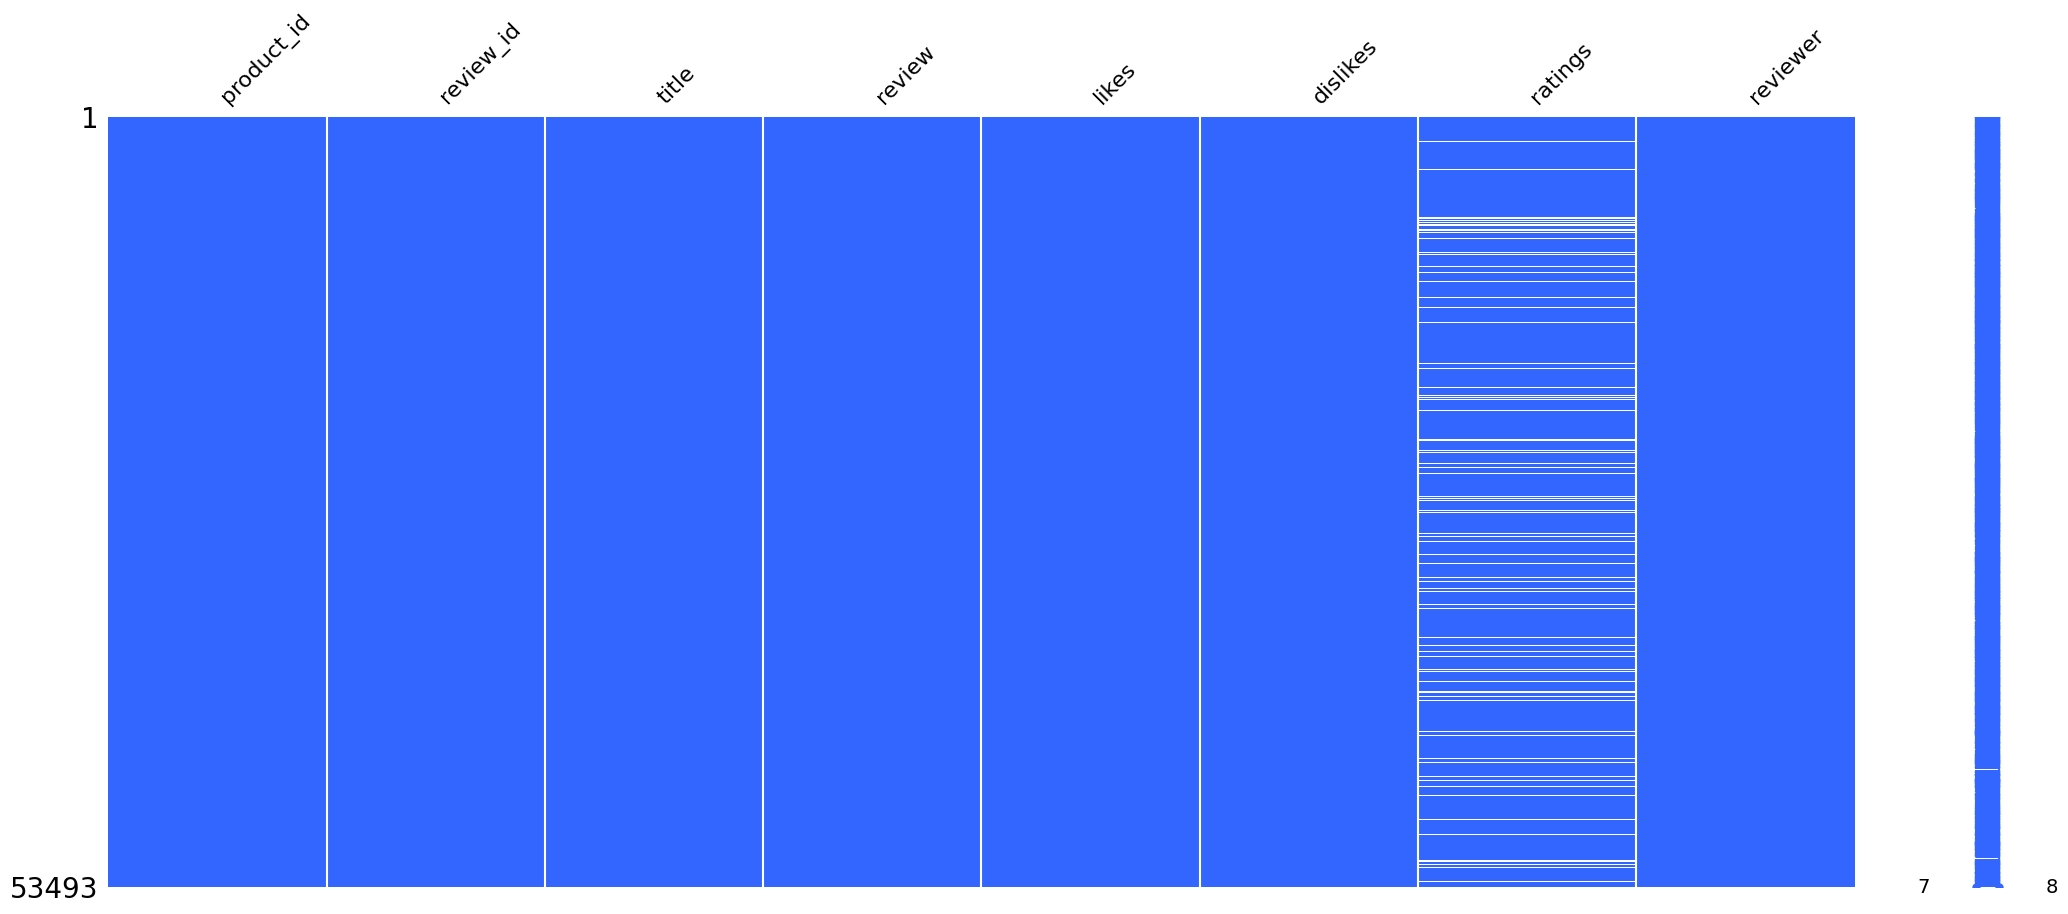

In [12]:
import missingno as msno
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [13]:
df.dropna(inplace=True, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48488 entries, 0 to 287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  48488 non-null  object
 1   review_id   48488 non-null  object
 2   title       48488 non-null  object
 3   review      48488 non-null  object
 4   likes       48488 non-null  object
 5   dislikes    48488 non-null  object
 6   ratings     48488 non-null  object
 7   reviewer    48488 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB


<Figure size 2500x2000 with 0 Axes>

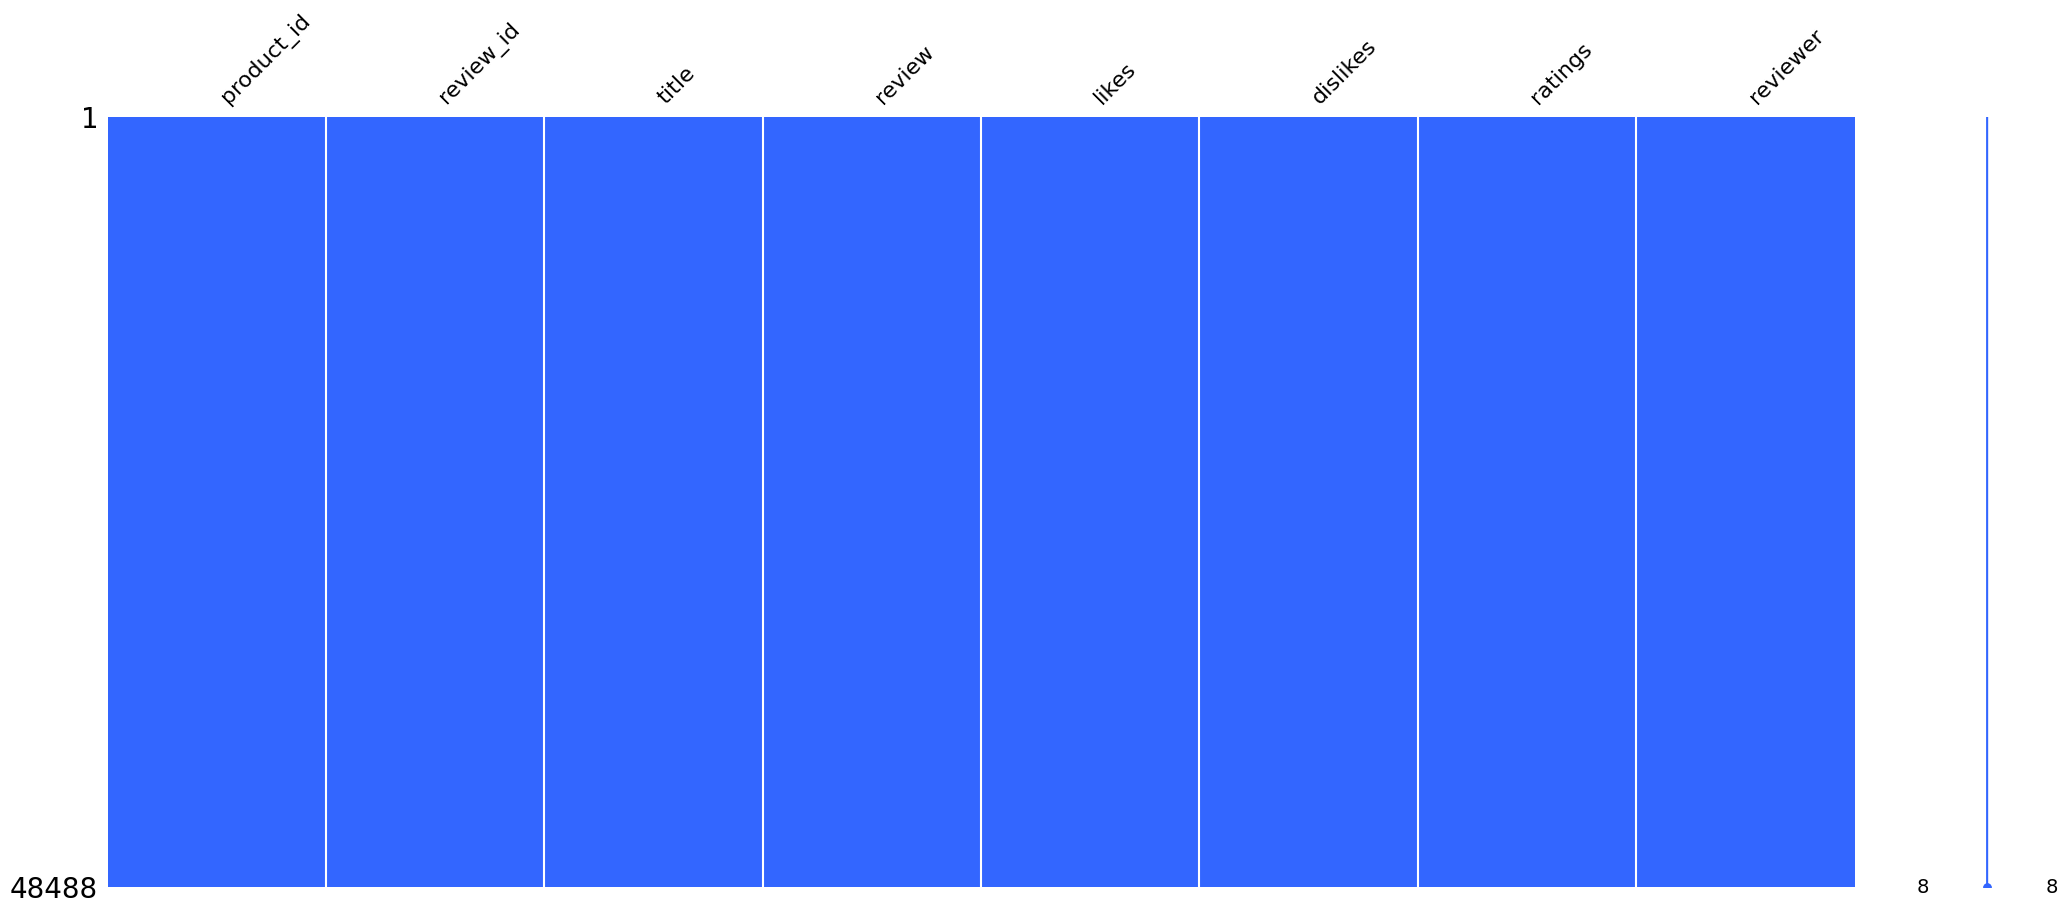

In [14]:
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [15]:
def remove_url(text):
    text = re.sub(r"http\S+", "", text)
    return text

In [16]:
sample = "ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 𝕀 𝕒𝕞 𝔸𝕟𝕜𝕚𝕥 𝔾𝕦𝕡𝕥𝕒 𝕙𝕒𝕧𝕚𝕟𝕘 𝕥𝕙𝕖 𝕗𝕠𝕝𝕝𝕠𝕨𝕚𝕟𝕘 𝕂𝕒𝕘𝕘𝕝𝕖 𝕡𝕣𝕠𝕗𝕚𝕝𝕖 \n https://www.kaggle.com/nkitgupta 𝕒𝕟𝕕 𝕀 𝕒𝕞 😊 𝕥𝕠 𝕔𝕣𝕖𝕒𝕥𝕖 𝕥𝕙𝕚𝕤 𝕟𝕠𝕥𝕖𝕓𝕠𝕠𝕜"
print(f"Text before removing url:- \n {sample}")

sample = remove_url(sample)
print(f"Text after removing url:- \n {sample}")

Text before removing url:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 𝕀 𝕒𝕞 𝔸𝕟𝕜𝕚𝕥 𝔾𝕦𝕡𝕥𝕒 𝕙𝕒𝕧𝕚𝕟𝕘 𝕥𝕙𝕖 𝕗𝕠𝕝𝕝𝕠𝕨𝕚𝕟𝕘 𝕂𝕒𝕘𝕘𝕝𝕖 𝕡𝕣𝕠𝕗𝕚𝕝𝕖 
 https://www.kaggle.com/nkitgupta 𝕒𝕟𝕕 𝕀 𝕒𝕞 😊 𝕥𝕠 𝕔𝕣𝕖𝕒𝕥𝕖 𝕥𝕙𝕚𝕤 𝕟𝕠𝕥𝕖𝕓𝕠𝕠𝕜
Text after removing url:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 𝕀 𝕒𝕞 𝔸𝕟𝕜𝕚𝕥 𝔾𝕦𝕡𝕥𝕒 𝕙𝕒𝕧𝕚𝕟𝕘 𝕥𝕙𝕖 𝕗𝕠𝕝𝕝𝕠𝕨𝕚𝕟𝕘 𝕂𝕒𝕘𝕘𝕝𝕖 𝕡𝕣𝕠𝕗𝕚𝕝𝕖 
  𝕒𝕟𝕕 𝕀 𝕒𝕞 😊 𝕥𝕠 𝕔𝕣𝕖𝕒𝕥𝕖 𝕥𝕙𝕚𝕤 𝕟𝕠𝕥𝕖𝕓𝕠𝕠𝕜


In [17]:
import unicodedata as uni

print(f"Text before Unicode Normalization:- \n {sample}")

sample = uni.normalize('NFKD', sample)
print(f"Text after Unicode Normalization:- \n {sample}")

Text before Unicode Normalization:- 
 ℍ𝕚 𝔼𝕧𝕖𝕣𝕪𝕠𝕟𝕖 𝕀 𝕒𝕞 𝔸𝕟𝕜𝕚𝕥 𝔾𝕦𝕡𝕥𝕒 𝕙𝕒𝕧𝕚𝕟𝕘 𝕥𝕙𝕖 𝕗𝕠𝕝𝕝𝕠𝕨𝕚𝕟𝕘 𝕂𝕒𝕘𝕘𝕝𝕖 𝕡𝕣𝕠𝕗𝕚𝕝𝕖 
  𝕒𝕟𝕕 𝕀 𝕒𝕞 😊 𝕥𝕠 𝕔𝕣𝕖𝕒𝕥𝕖 𝕥𝕙𝕚𝕤 𝕟𝕠𝕥𝕖𝕓𝕠𝕠𝕜
Text after Unicode Normalization:- 
 Hi Everyone I am Ankit Gupta having the following Kaggle profile 
  and I am 😊 to create this notebook


In [18]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 551.0 kB/s eta 0:00:00


In [19]:
import demoji


def handle_emoji(string):
    emojis = demoji.findall(string)

    for emoji in emojis:
        string = string.replace(emoji, " " + emojis[emoji].split(":")[0])

    return string


print(f"Before Handling emoji:- \n {sample}")
print(f"After Handling emoji:- \n {handle_emoji(sample)}")

Before Handling emoji:- 
 Hi Everyone I am Ankit Gupta having the following Kaggle profile 
  and I am 😊 to create this notebook
After Handling emoji:- 
 Hi Everyone I am Ankit Gupta having the following Kaggle profile 
  and I am  smiling face with smiling eyes to create this notebook


In [20]:
def word_tokenizer(text):
    text = text.lower()
    text = text.split()

    return text


sample = "Hi Everyone I am Ankit Gupta."
print(sample)
print(word_tokenizer(sample))

Hi Everyone I am Ankit Gupta.
['hi', 'everyone', 'i', 'am', 'ankit', 'gupta.']


In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
from nltk.corpus import stopwords

en_stopwords = set(stopwords.words('english'))
print(f"Stop Words in English : \n{ en_stopwords}")

Stop Words in English : 
{'up', 'those', 'from', 're', "you're", 'such', "you've", "it's", 'your', 'they', 'out', 'when', "you'd", 'into', 'in', 'because', 'y', 'whom', "doesn't", 'did', 'hasn', 'd', 'an', 'the', 'his', 'its', "hadn't", 'she', "haven't", 'more', 'through', 'of', 'before', 'again', 'during', 'nor', 'further', 'me', 'now', 'be', 'while', 'he', 'below', 'and', 'been', 'didn', 'hers', "weren't", 'myself', 'being', 'most', 'between', 'with', 'shan', 'after', 'which', 've', 'them', 'was', 'wasn', 'for', 'this', 'haven', "aren't", 'do', "wouldn't", 'having', 'so', "isn't", 'how', 'about', 'should', 'mightn', "wasn't", 'theirs', 'ourselves', 'll', 'will', 'ours', "she's", 'by', "that'll", 'some', 'does', 'any', 'if', 'to', 'doing', 'both', 'herself', 'yourself', 'have', 'you', 't', 'same', 'above', 'ma', 'weren', 'other', 'not', 'don', "you'll", 'over', "hasn't", 'm', 'her', 'him', 'yours', 'a', 'o', "mustn't", "mightn't", 'we', 'needn', 'only', 'all', "should've", 'at', "won'

In [23]:
def remove_stopwords(text):
    text = [word for word in text if word not in en_stopwords]
    return text


print(f"Before removing stopwords : {word_tokenizer(sample)}")
print(f"After removing stopwords : {remove_stopwords(word_tokenizer(sample))}")

Before removing stopwords : ['hi', 'everyone', 'i', 'am', 'ankit', 'gupta.']
After removing stopwords : ['hi', 'everyone', 'ankit', 'gupta.']


In [24]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer

stemmer = PorterStemmer()
# stemmer = LancasterStemmer()


def stemming(text):

    text = [stemmer.stem(word) for word in text]
    return text


sample = "I am creating a Notebook"
print(f"Before Stemming : {(sample)}")
print(f"After Stemming : {stemming(word_tokenizer(sample))}")

Before Stemming : I am creating a Notebook
After Stemming : ['i', 'am', 'creat', 'a', 'notebook']


In [25]:
!pip install spacy

In [26]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
import spacy

sp = spacy.load("en_core_web_sm")

In [28]:
def lemmatization(text):

    #text = [sp(word).lemma_ for word in text]

    text = " ".join(text)
    token = sp(text)

    text = [word.lemma_ for word in token]
    return text


print(f"Before Lemmatization : {word_tokenizer(sample)}")
print(f"After Lemmatization : {lemmatization(word_tokenizer(sample))}")



Before Lemmatization : ['i', 'am', 'creating', 'a', 'notebook']
After Lemmatization : ['I', 'be', 'create', 'a', 'notebook']


In [29]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=9b544dcca29647568603a68722645caeeac21764bb053690291d726b92a976a5
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [30]:
from langdetect import detect


en_text = u""""Hi Everyone I am Ankit Gupta."""
print(f" {en_text} : {detect(en_text)}")

hindi_text = u"""मेरा नाम अंकित गुप्ता है और मैं एक छात्र हूँ"""
print(f"{hindi_text} : {detect(hindi_text)}")

 "Hi Everyone I am Ankit Gupta. : tl
मेरा नाम अंकित गुप्ता है और मैं एक छात्र हूँ : hi


In [31]:
df_temp = df.copy()

In [32]:
def label(y):
    if y == '5':
        return 1
    elif y == '4':
        return 1
    else:
        return 0

from tqdm import tqdm

tqdm.pandas()

df_temp['y'] = df_temp.ratings.progress_map(label)

100%|██████████| 48488/48488 [00:00<00:00, 345285.93it/s]


In [33]:
df_temp = df_temp[['review', 'y', 'ratings']]

In [34]:
df_temp.head()

,review,y,ratings
0,Wow superb I love it❤️👍 battery backup so nice 👍👍,1,5
1,Mobile So Good In Range Redmi 9a Has Miui 12 L...,1,4
2,Wonderful device and smart phone best camera b...,1,5
3,Very good mobile. Value for money. Battery bac...,1,5
4,Really great.... value for money...,1,5


In [35]:
df_temp.y.value_counts()

y
1    44751
0     3737
Name: count, dtype: int64

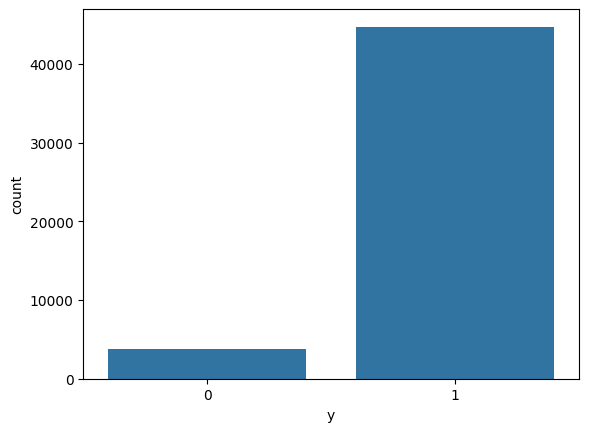

In [36]:
import seaborn as sns

sns.countplot(x = "y", data = df_temp)
plt.show()

In [37]:
df_temp2 = df_temp[(df_temp['ratings'] == '5')]

In [38]:
positive = list(df_temp2[(df_temp2['review'].str.len() > 100) & (df_temp2['review'].str.len() < 350)]['review'])
len(positive)

4803

In [39]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 2.8 MB/s eta 0:00:00


In [40]:
import nlpaug.augmenter.word as naw

In [41]:
positive[41:49]

["An amazing smartphone for the price though i didn't like the colors compared to a realme phone in the same price range. It's a reall good second smartphone if you already have a primary device.",
 "Nice product according to its budget. But it's hard to play high Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (High graphics game) purpose, then don't go for 3GB or 2 GB RAM and the rest it works very well.",
 'I gave this phone to my wife as a gift and she loved it so much that she gets great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been better',
 'Very good handset at this price. Nice and great performance. Battery backup is also trustworthy. There is no issue till date after using for a period of 5days. Overall u can buy this phone without hesitation',
 'I am happy with your productus policy of 

In [42]:
aug = naw.AntonymAug(name='Antonym_Aug', aug_min=1, aug_max=10, aug_p=0.3, lang='eng', stopwords=en_stopwords, tokenizer=None,
                     reverse_tokenizer=None, stopwords_regex=None, verbose=0)

aug_negative = aug.augment(positive)
len(aug_negative)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


4803

In [43]:
aug_negative[41:49]

["An amazing smartphone for the price though i didn ' t like the colors compared to a realme phone in the same price range. It ' s a reall bad second smartphone if you already have a secondary device.",
 "Nice product according to its budget. But it ' s hard to play low Graphics games like pubg on 3GB RAM. It lags even when you play at Smooth Graphics settings. If this is for gaming (Low graphics game) purpose, then don ' t malfunction for 3GB or 2 GB RAM and the rest it malfunction very badly.",
 'I starve this phone to my wife as a gift and she hate it so little that she end great performance and photos of games',
 'Every thing is great about the phone but a micro USB connector with a 5000 mah battery kind of suck a type c connector would have been bad',
 'Very bad handset at this price. Nice and great performance. Battery backup is also untrustworthy. There is no issue till date after using for a period of 5days. Overall u can sell this phone without hesitation',
 'I am unhappy with

In [44]:
df_negative = pd.DataFrame({"review" : aug_negative, 'y' : [0]*len(aug_negative)})

In [45]:
df_positive = pd.DataFrame({"review" : positive, 'y' : [1]*len(positive)})

In [46]:
df_temp = pd.concat([df_negative, df_positive]).sample(frac = 1, random_state = 11).reset_index(drop=True)

In [47]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9606 entries, 0 to 9605
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  9606 non-null   object
 1   y       9606 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 150.2+ KB


In [48]:
df_temp.head()

,review,y
0,great phone in budget. .. pubg performance was...,0
1,Best Smartphone by Mi in this Range. . come fo...,0
2,Bad smooth phone. . and back camera quality is...,0
3,Thise is very nice mobile ...I like it very mu...,1
4,I m meagerly fall short of 👍 All section r sup...,0


In [49]:
df = df_temp

In [50]:
def preprocessing(text):

    text = remove_url(text)
    text = uni.normalize('NFKD', text)
    text = handle_emoji(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = word_tokenizer(text)
    # text = stemming(text)
    text = lemmatization(text)
    text = remove_stopwords(text)
    text = " ".join(text)

    return text


In [51]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review'] = df['review'].progress_map(preprocessing)

100%|██████████| 9606/9606 [02:33<00:00, 62.63it/s]


In [52]:
df.head()

,review,y,clean_review
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...
1,Best Smartphone by Mi in this Range. . come fo...,0,well smartphone mi range come r confuse samsun...
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...
4,I m meagerly fall short of 👍 All section r sup...,0,I meagerly fall short thumb section r superb d...


In [53]:
reviews = df.clean_review.values.tolist()

In [54]:
from tqdm import tqdm

tqdm.pandas()

df['clean_review2'] = df['clean_review'].progress_map(word_tokenizer)

100%|██████████| 9606/9606 [00:00<00:00, 205901.96it/s]


In [55]:
df.head()

,review,y,clean_review,clean_review2
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug..."
1,Best Smartphone by Mi in this Range. . come fo...,0,well smartphone mi range come r confuse samsun...,"[well, smartphone, mi, range, come, r, confuse..."
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba..."
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"[thise, nice, mobile, i, like, much, delivery,..."
4,I m meagerly fall short of 👍 All section r sup...,0,I meagerly fall short thumb section r superb d...,"[i, meagerly, fall, short, thumb, section, r, ..."


In [56]:
data_words = df['clean_review2'].values.tolist()
len(data_words)

9606

In [57]:
!pip install gensim

In [58]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [59]:
from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[(0,
  '0.051*"i" + 0.026*"mobile" + 0.025*"camera" + 0.017*"phone" + '
  '0.017*"awesome" + 0.016*"price" + 0.012*"bad" + 0.011*"product" + '
  '0.010*"also" + 0.010*"great"'),
 (1,
  '0.084*"good" + 0.031*"camera" + 0.021*"performance" + 0.021*"mobile" + '
  '0.019*"battery" + 0.017*"i" + 0.015*"also" + 0.014*"money" + 0.012*"value" '
  '+ 0.012*"price"'),
 (2,
  '0.042*"i" + 0.035*"phone" + 0.022*"camera" + 0.019*"good" + 0.019*"face" + '
  '0.018*"flipkart" + 0.017*"bad" + 0.015*"smile" + 0.015*"thank" + '
  '0.014*"battery"'),
 (3,
  '0.043*"i" + 0.043*"phone" + 0.029*"camera" + 0.028*"bad" + 0.018*"battery" '
  '+ 0.016*"awesome" + 0.016*"evil" + 0.012*"mobile" + 0.011*"price" + '
  '0.011*"like"'),
 (4,
  '0.072*"good" + 0.042*"phone" + 0.039*"camera" + 0.028*"battery" + '
  '0.023*"quality" + 0.018*"display" + 0.017*"i" + 0.012*"mobile" + '
  '0.012*"also" + 0.012*"price"'),
 (5,
  '0.057*"phone" + 0.043*"i" + 0.024*"good" + 0.023*"product" + 0.016*"camera" '
  '+ 0.015*"batter

In [60]:
%%time
from gensim.models import FastText
fasttext_model = FastText(data_words, vector_size= 100, window=5, min_count=5, workers=4,sg=1)

CPU times: user 15.7 s, sys: 956 ms, total: 16.6 s
Wall time: 13.1 s


In [61]:
cpath="/content/modelsave/"
fasttext_model.save(cpath+"FastText-Model-For-ABSA.bin")

In [62]:
fasttext_model.wv.n_similarity("I really like the camera of this phone", "battery")

0.9501391

In [63]:
aspects = ["phone", "camera", "battery", "delivery", "processor"]

def get_similarity(text, aspect):
    try:
        text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

In [64]:
from tqdm import tqdm
tqdm.pandas()
for aspect in aspects:
    df[aspect] = df['clean_review2'].progress_map(lambda text: get_similarity(text, aspect))

100%|██████████| 9606/9606 [00:12<00:00, 768.77it/s]


In [65]:
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"[great, phone, budget, pubg, performance, roug...",0.900689,0.890224,0.959075,0.910875,0.913764
1,Best Smartphone by Mi in this Range. . come fo...,0,well smartphone mi range come r confuse samsun...,"[well, smartphone, mi, range, come, r, confuse...",0.904828,0.862080,0.950976,0.948471,0.883439
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"[bad, smooth, phone, back, camera, quality, ba...",0.872466,0.905141,0.955897,0.920294,0.919638
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"[thise, nice, mobile, i, like, much, delivery,...",0.876209,0.852391,0.922734,0.962211,0.859909
4,I m meagerly fall short of 👍 All section r sup...,0,I meagerly fall short thumb section r superb d...,"[i, meagerly, fall, short, thumb, section, r, ...",0.854000,0.885204,0.970690,0.962319,0.911627


In [66]:
spath="/content/dataset/"
df.to_csv(spath+"Clean_Flipkart_Product.csv", index = False)

In [67]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler
import warnings

In [68]:
class config:
    warnings.filterwarnings("ignore", category = UserWarning)
    IMG_SIZE = (224,224)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
    FOLDS = 5
    SHUFFLE = True
    BATCH_SIZE = 32
    LR = 0.01
    EPOCHS = 15
    EMB_DIM = 100
    MAX_LEN = 20
    MODEL_PATH = "./Models/MyModel.pt"

In [69]:
df = pd.read_csv("/content/dataset/Clean_Flipkart_Product.csv")
df.head()

,review,y,clean_review,clean_review2,phone,camera,battery,delivery,processor
0,great phone in budget. .. pubg performance was...,0,great phone budget pubg performance rough came...,"['great', 'phone', 'budget', 'pubg', 'performa...",0.900689,0.890224,0.959075,0.910875,0.913764
1,Best Smartphone by Mi in this Range. . come fo...,0,well smartphone mi range come r confuse samsun...,"['well', 'smartphone', 'mi', 'range', 'come', ...",0.904828,0.862080,0.950976,0.948471,0.883439
2,Bad smooth phone. . and back camera quality is...,0,bad smooth phone back camera quality bad rear ...,"['bad', 'smooth', 'phone', 'back', 'camera', '...",0.872466,0.905141,0.955897,0.920294,0.919638
3,Thise is very nice mobile ...I like it very mu...,1,thise nice mobile I like much delivery also fa...,"['thise', 'nice', 'mobile', 'i', 'like', 'much...",0.876209,0.852391,0.922735,0.962211,0.859909
4,I m meagerly fall short of 👍 All section r sup...,0,I meagerly fall short thumb section r superb d...,"['i', 'meagerly', 'fall', 'short', 'thumb', 's...",0.854000,0.885204,0.970690,0.962319,0.911627


In [70]:
class Vocabulary:

    '''
    __init__ method is called by default as soon as an object of this class is initiated
    we use this method to initiate our vocab dictionaries
    '''
    def __init__(self, freq_threshold, max_size):
        '''
        freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
        max_size : max source vocab size. Eg. if set to 10,000, we pick the top 10,000 most frequent words and discard others
        '''
        #initiate the index to token dict
        ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
        ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
        ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
        ## <UNK> -> words which are not found in the vocab are replace by this token
        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}
        #initiate the token to index dict
        self.stoi = {k:j for j,k in self.itos.items()}

        self.freq_threshold = freq_threshold
        self.max_size = max_size

    '''
    __len__ is used by dataloader later to create batches
    '''
    def __len__(self):
        return len(self.itos)

    '''
    a simple tokenizer to split on space and converts the sentence to list of words
    '''
    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]

    '''
    build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
    output ex. for stoi -> {'the':5, 'a':6, 'an':7}
    '''
    def build_vocabulary(self, sentence_list):
        #calculate the frequencies of each word first to remove the words with freq < freq_threshold
        frequencies = {}  #init the freq dict
        idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

        #calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1


        #limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold}

        #limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk

        #create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1


    '''
    convert the list of words to a list of corresponding indexes
    '''
    def numericalize(self, text):
        #tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []
        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else: #out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])

        return numericalized_text

In [71]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    source_column : the name of source text column in the dataframe
    transform : If we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    '''

    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 , transform=None):

        self.df = df
        self.transform = transform

        #get source and target texts
        self.source_texts = self.df[source_column]


        ##VOCAB class has been created above
        #Initialize source vocab object and build vocabulary
        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())


    def __len__(self):
        return len(self.df)

    '''
    __getitem__ runs on 1 example at a time. Here, we get an example at index and return its numericalize source and
    target values using the vocabulary objects we created in __init__
    '''
    def __getitem__(self, index):
        source_text = self.source_texts[index]

        if self.transform is not None:
            source_text = self.transform(source_text)

        #numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])

        #convert the list to tensor and return
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

In [72]:
dataset = CustomDataset(df, "clean_review")

In [73]:
len(dataset.source_vocab.stoi)

3304

In [74]:
import pickle

with open('dataset-new', 'wb') as dataset_file:

  # Step 3
    pickle.dump(dataset, dataset_file, pickle.HIGHEST_PROTOCOL)

In [75]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable = False):

    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0

    for i, word in enumerate(target_vocab):
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1

    print(f"Words found are : {words_found}")

    weights_matrix = torch.tensor(weights_matrix, dtype = torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)
    print(emb_layer)
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer

In [76]:
class MyCollate:
    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen


    #__call__: a default method
    ##   First the obj is created using MyCollate(pad_idx) in data loader
    ##   Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        #get all source indexed sentences of the batch
        source = [item[0] for item in batch]
        #pad them using pad_sequence method from pytorch.
#         source = pad_sequence(source, batch_first=False, padding_value = self.pad_idx)

        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)

        for idx, text in enumerate(source):

            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]


        #get all target indexed sentences of the batch
        target = [item[1] for item in batch]

        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target

In [77]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()
#         self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()



    def forward(self, text):

        max_len, N = text.shape
        hidden = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        memory = torch.zeros((2, N , self.hidden_dim),
                          dtype=torch.float)
        hidden = hidden.to(config.DEVICE)
        memory = memory.to(config.DEVICE)
        embedded = self.embedding(text)
        output, hidden = self.lstm(embedded, (hidden, memory))
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        y_pred = output[-1,:,:]
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        y_pred = self.sigmoid(y_pred)

        return y_pred

In [78]:
def train_epochs(dataloader,model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0

    model.train()

    for review, label in tqdm(dataloader):

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        train_correct += (prediction == label).float().sum()

    return train_loss, train_correct

In [79]:
def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0

    model.eval()
#     hidden = model.init_hidden(config.BATCH_SIZE)

    for review, label in dataloader:

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)

        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)

        val_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        val_correct += (prediction == label).float().sum()
#         prediction =
    return val_loss, val_correct

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:09<00:00, 24.56it/s]


| Train Loss : 0.692616670160229 |  Val Loss : 0.690860913459766 | Train Acc : 50.48152160644531 | Val Acc : 50.936527252197266 |


100%|██████████| 241/241 [00:08<00:00, 27.37it/s]


| Train Loss : 0.6892374275501416 |  Val Loss : 0.6862127181766681 | Train Acc : 55.6220703125 | Val Acc : 50.52029037475586 |


100%|██████████| 241/241 [00:08<00:00, 27.67it/s]


| Train Loss : 0.6750613710707765 |  Val Loss : 0.6517271988101606 | Train Acc : 60.20302200317383 | Val Acc : 52.75754165649414 |


100%|██████████| 241/241 [00:09<00:00, 25.36it/s]


| Train Loss : 0.49230556894735644 |  Val Loss : 0.20294659743696047 | Train Acc : 78.14939880371094 | Val Acc : 93.34027099609375 |


100%|██████████| 241/241 [00:12<00:00, 19.07it/s]


| Train Loss : 0.2980227700634852 |  Val Loss : 0.17377915717545087 | Train Acc : 88.39146423339844 | Val Acc : 93.91259002685547 |


100%|██████████| 241/241 [00:09<00:00, 25.66it/s]


| Train Loss : 0.24929322011939473 |  Val Loss : 0.21881331334377055 | Train Acc : 90.12232971191406 | Val Acc : 90.63475799560547 |


100%|██████████| 241/241 [00:09<00:00, 26.30it/s]


| Train Loss : 0.2199578596543732 |  Val Loss : 0.14688958523021653 | Train Acc : 91.31962585449219 | Val Acc : 95.00520324707031 |


100%|██████████| 241/241 [00:08<00:00, 28.39it/s]


| Train Loss : 0.19323812275426827 |  Val Loss : 0.29184538205459515 | Train Acc : 92.5429458618164 | Val Acc : 88.0333023071289 |


100%|██████████| 241/241 [00:09<00:00, 25.77it/s]


| Train Loss : 0.18308920642813858 |  Val Loss : 0.15419525366264875 | Train Acc : 93.0114517211914 | Val Acc : 94.95317077636719 |


100%|██████████| 241/241 [00:09<00:00, 25.81it/s]


| Train Loss : 0.18860104952816198 |  Val Loss : 0.15554471638801814 | Train Acc : 92.7771987915039 | Val Acc : 95.0572280883789 |


100%|██████████| 241/241 [00:09<00:00, 25.81it/s]


| Train Loss : 0.18182772681900514 |  Val Loss : 0.42630556045908335 | Train Acc : 92.84226989746094 | Val Acc : 82.83039093017578 |


100%|██████████| 241/241 [00:08<00:00, 27.25it/s]


| Train Loss : 0.1692839612304885 |  Val Loss : 0.13460949816305914 | Train Acc : 93.4148941040039 | Val Acc : 95.0572280883789 |


100%|██████████| 241/241 [00:08<00:00, 28.52it/s]


| Train Loss : 0.16749427743151374 |  Val Loss : 0.14414517403532762 | Train Acc : 93.45393371582031 | Val Acc : 94.53694152832031 |


100%|██████████| 241/241 [00:09<00:00, 25.65it/s]


| Train Loss : 0.1616065674953508 |  Val Loss : 0.3206888229530944 | Train Acc : 93.83133697509766 | Val Acc : 84.8074951171875 |


100%|██████████| 241/241 [00:09<00:00, 25.73it/s]


| Train Loss : 0.15518585147936323 |  Val Loss : 0.12592445738888836 | Train Acc : 93.96147918701172 | Val Acc : 95.26535034179688 |


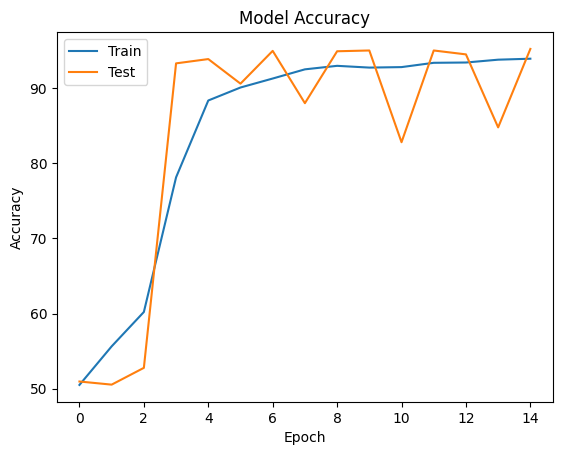

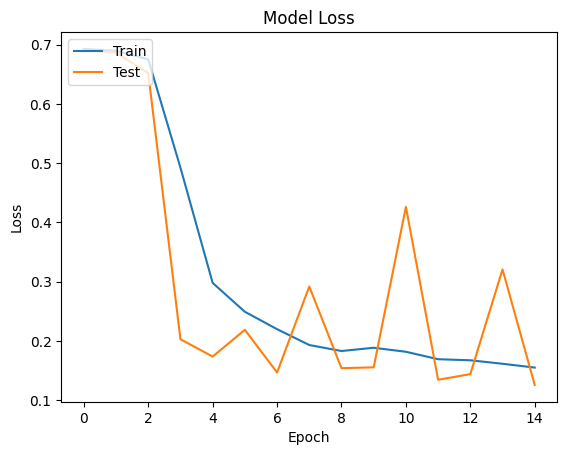

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:09<00:00, 25.59it/s]


| Train Loss : 0.6924698858347975 |  Val Loss : 0.6905965912720612 | Train Acc : 50.72218704223633 | Val Acc : 56.48099899291992 |


100%|██████████| 241/241 [00:09<00:00, 26.12it/s]


| Train Loss : 0.6876918972352921 |  Val Loss : 0.6837101686999923 | Train Acc : 56.39557647705078 | Val Acc : 56.4289436340332 |


100%|██████████| 241/241 [00:09<00:00, 25.38it/s]


| Train Loss : 0.6458956013116731 |  Val Loss : 0.7777304618325102 | Train Acc : 64.86662292480469 | Val Acc : 50.442474365234375 |


100%|██████████| 241/241 [00:08<00:00, 26.88it/s]


| Train Loss : 0.43044813529927 |  Val Loss : 0.24734860895233562 | Train Acc : 81.61353302001953 | Val Acc : 91.3586654663086 |


100%|██████████| 241/241 [00:09<00:00, 25.67it/s]


| Train Loss : 0.26410766264124397 |  Val Loss : 0.19483621160556475 | Train Acc : 90.08457946777344 | Val Acc : 92.66007232666016 |


100%|██████████| 241/241 [00:09<00:00, 25.42it/s]


| Train Loss : 0.227363730229258 |  Val Loss : 0.17295363675710831 | Train Acc : 91.3077392578125 | Val Acc : 93.49297332763672 |


100%|██████████| 241/241 [00:09<00:00, 25.54it/s]


| Train Loss : 0.18919782532486887 |  Val Loss : 0.2980463122041195 | Train Acc : 92.72608947753906 | Val Acc : 88.49557495117188 |


100%|██████████| 241/241 [00:09<00:00, 24.57it/s]


| Train Loss : 0.18245860813264345 |  Val Loss : 0.3202857726536214 | Train Acc : 93.10344696044922 | Val Acc : 85.63248443603516 |


100%|██████████| 241/241 [00:08<00:00, 27.49it/s]


| Train Loss : 0.16871649999469615 |  Val Loss : 0.19939733671294965 | Train Acc : 93.48080444335938 | Val Acc : 92.19156646728516 |


100%|██████████| 241/241 [00:09<00:00, 25.64it/s]


| Train Loss : 0.16467021267495144 |  Val Loss : 0.1909159192866813 | Train Acc : 93.58490753173828 | Val Acc : 92.34773254394531 |


100%|██████████| 241/241 [00:09<00:00, 25.56it/s]


| Train Loss : 0.1558275657151532 |  Val Loss : 0.9604517539305237 | Train Acc : 93.87117767333984 | Val Acc : 72.09786987304688 |


100%|██████████| 241/241 [00:09<00:00, 25.37it/s]


| Train Loss : 0.16530045848739713 |  Val Loss : 0.5178543644686235 | Train Acc : 93.83213806152344 | Val Acc : 80.79125213623047 |


100%|██████████| 241/241 [00:08<00:00, 27.72it/s]


| Train Loss : 0.15335489395925886 |  Val Loss : 0.34232673817580855 | Train Acc : 94.0923843383789 | Val Acc : 83.81051635742188 |


100%|██████████| 241/241 [00:08<00:00, 27.61it/s]


| Train Loss : 0.14385546375909503 |  Val Loss : 0.1543127835370922 | Train Acc : 94.43070983886719 | Val Acc : 94.48204040527344 |


100%|██████████| 241/241 [00:09<00:00, 25.41it/s]


| Train Loss : 0.14652045612697895 |  Val Loss : 0.1599302093536224 | Train Acc : 94.23551940917969 | Val Acc : 94.06558990478516 |


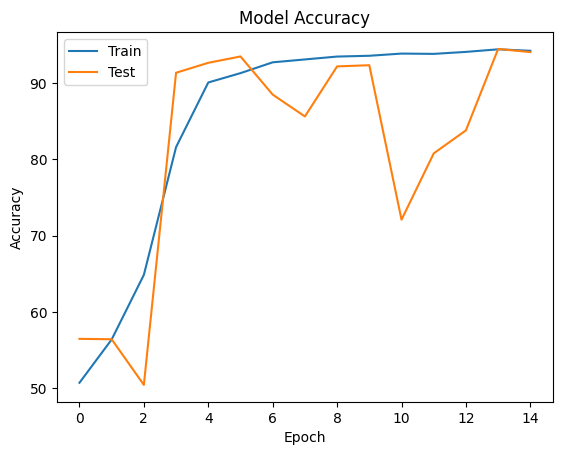

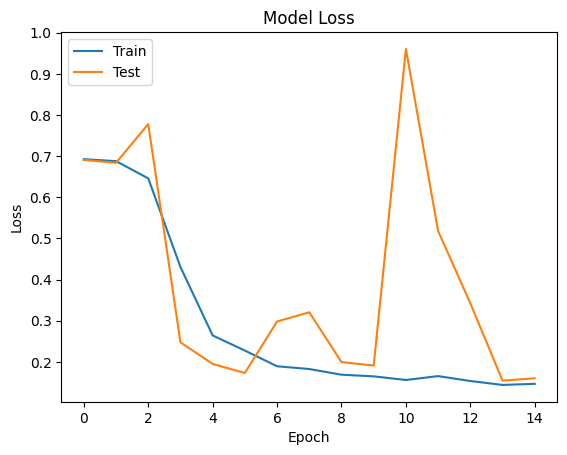

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:09<00:00, 24.66it/s]


| Train Loss : 0.6912215451257292 |  Val Loss : 0.6888539046436967 | Train Acc : 53.05139923095703 | Val Acc : 57.00156021118164 |


100%|██████████| 241/241 [00:09<00:00, 24.95it/s]


| Train Loss : 0.68401822499354 |  Val Loss : 0.6763064430319723 | Train Acc : 58.68574905395508 | Val Acc : 63.45653533935547 |


100%|██████████| 241/241 [00:09<00:00, 25.12it/s]


| Train Loss : 0.6015129130384561 |  Val Loss : 0.4489547454522712 | Train Acc : 70.61808776855469 | Val Acc : 77.98021697998047 |


100%|██████████| 241/241 [00:08<00:00, 28.22it/s]


| Train Loss : 0.3394494424315343 |  Val Loss : 0.21794665393258122 | Train Acc : 86.5842514038086 | Val Acc : 92.45184326171875 |


100%|██████████| 241/241 [00:09<00:00, 25.16it/s]


| Train Loss : 0.2619096069645789 |  Val Loss : 0.40424021656437353 | Train Acc : 89.68119812011719 | Val Acc : 82.40499877929688 |


100%|██████████| 241/241 [00:09<00:00, 25.24it/s]


| Train Loss : 0.22208672468450524 |  Val Loss : 0.17802309052691925 | Train Acc : 91.64606475830078 | Val Acc : 93.33679962158203 |


100%|██████████| 241/241 [00:09<00:00, 25.43it/s]


| Train Loss : 0.19300560609970144 |  Val Loss : 0.6190718560557636 | Train Acc : 92.68704986572266 | Val Acc : 79.1775131225586 |


100%|██████████| 241/241 [00:09<00:00, 25.43it/s]


| Train Loss : 0.19041207623325662 |  Val Loss : 0.14898275193030608 | Train Acc : 92.63500213623047 | Val Acc : 94.79438018798828 |


100%|██████████| 241/241 [00:09<00:00, 26.33it/s]


| Train Loss : 0.1824437002329642 |  Val Loss : 0.29964127515252137 | Train Acc : 92.97332763671875 | Val Acc : 88.44351959228516 |


100%|██████████| 241/241 [00:08<00:00, 28.10it/s]


| Train Loss : 0.17468107550095333 |  Val Loss : 0.15994458557685903 | Train Acc : 93.55888366699219 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:09<00:00, 25.41it/s]


| Train Loss : 0.1750877905935146 |  Val Loss : 0.15177699828783184 | Train Acc : 93.07742309570312 | Val Acc : 93.96147918701172 |


100%|██████████| 241/241 [00:09<00:00, 25.26it/s]


| Train Loss : 0.16602867143634628 |  Val Loss : 0.15342800497605366 | Train Acc : 93.41574096679688 | Val Acc : 93.85736846923828 |


100%|██████████| 241/241 [00:09<00:00, 25.41it/s]


| Train Loss : 0.1587925138842695 |  Val Loss : 0.2290437511870912 | Train Acc : 93.63695526123047 | Val Acc : 89.9531478881836 |


100%|██████████| 241/241 [00:09<00:00, 25.84it/s]


| Train Loss : 0.15807743856735484 |  Val Loss : 0.17615992572368983 | Train Acc : 94.04033660888672 | Val Acc : 93.12857818603516 |


100%|██████████| 241/241 [00:09<00:00, 25.07it/s]


| Train Loss : 0.15728642012422242 |  Val Loss : 0.20629200360721742 | Train Acc : 93.72804260253906 | Val Acc : 91.04632568359375 |


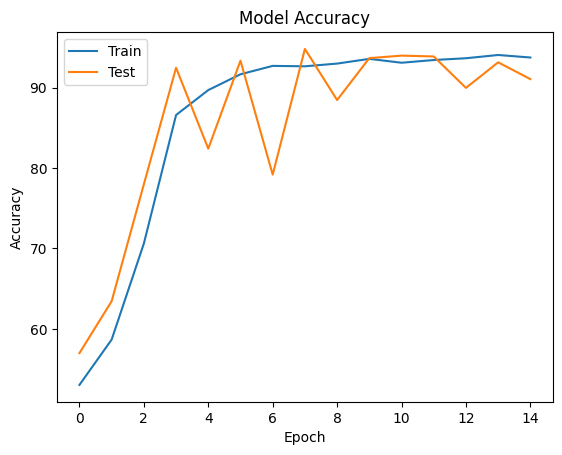

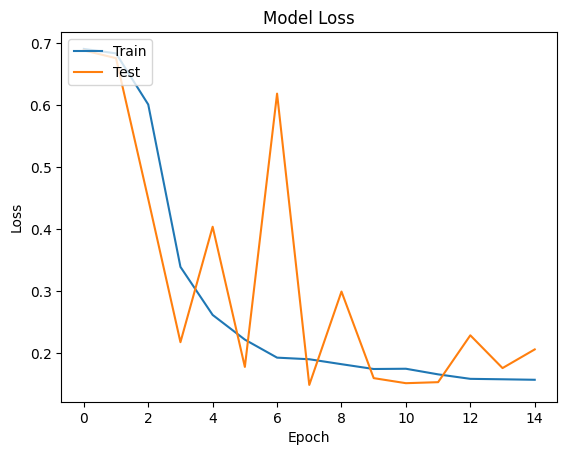

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:08<00:00, 27.74it/s]


| Train Loss : 0.6923711364270808 |  Val Loss : 0.6906719022216677 | Train Acc : 51.94534683227539 | Val Acc : 53.40968322753906 |


100%|██████████| 241/241 [00:09<00:00, 25.10it/s]


| Train Loss : 0.6869403120442963 |  Val Loss : 0.6847950335531915 | Train Acc : 56.69485855102539 | Val Acc : 48.88079071044922 |


100%|██████████| 241/241 [00:09<00:00, 25.25it/s]


| Train Loss : 0.6204391507801486 |  Val Loss : 1.6047271182503646 | Train Acc : 67.5211410522461 | Val Acc : 48.67256546020508 |


100%|██████████| 241/241 [00:09<00:00, 25.21it/s]


| Train Loss : 0.37678744227964145 |  Val Loss : 0.5663413185876431 | Train Acc : 84.7885513305664 | Val Acc : 75.16918182373047 |


100%|██████████| 241/241 [00:09<00:00, 26.08it/s]


| Train Loss : 0.24386370694901002 |  Val Loss : 0.20974479152596537 | Train Acc : 90.68315124511719 | Val Acc : 92.81623840332031 |


100%|██████████| 241/241 [00:08<00:00, 28.04it/s]


| Train Loss : 0.22584814592934152 |  Val Loss : 0.22643477378198795 | Train Acc : 91.25569152832031 | Val Acc : 91.8271713256836 |


100%|██████████| 241/241 [00:09<00:00, 25.20it/s]


| Train Loss : 0.1932740209392704 |  Val Loss : 0.7207234631923262 | Train Acc : 92.71307373046875 | Val Acc : 70.01561737060547 |


100%|██████████| 241/241 [00:09<00:00, 25.12it/s]


| Train Loss : 0.1912645629119363 |  Val Loss : 0.1640464191648378 | Train Acc : 92.55693054199219 | Val Acc : 94.06558990478516 |


100%|██████████| 241/241 [00:09<00:00, 25.17it/s]


| Train Loss : 0.17168593243801833 |  Val Loss : 1.7904020189184002 | Train Acc : 93.41574096679688 | Val Acc : 52.00416564941406 |


100%|██████████| 241/241 [00:09<00:00, 25.64it/s]


| Train Loss : 0.19307712329601265 |  Val Loss : 0.1606768544032231 | Train Acc : 92.55693054199219 | Val Acc : 93.75325775146484 |


100%|██████████| 241/241 [00:08<00:00, 27.64it/s]


| Train Loss : 0.17057651199713086 |  Val Loss : 0.1959065558802858 | Train Acc : 93.25959777832031 | Val Acc : 91.72306060791016 |


100%|██████████| 241/241 [00:09<00:00, 25.62it/s]


| Train Loss : 0.1668376559240134 |  Val Loss : 0.8430981487113322 | Train Acc : 93.51984405517578 | Val Acc : 69.70327758789062 |


100%|██████████| 241/241 [00:10<00:00, 22.88it/s]


| Train Loss : 0.1645347463896543 |  Val Loss : 0.16500181825380658 | Train Acc : 93.59791564941406 | Val Acc : 93.33679962158203 |


100%|██████████| 241/241 [00:09<00:00, 25.17it/s]


| Train Loss : 0.15166990933824687 |  Val Loss : 0.22803909711858267 | Train Acc : 94.17046356201172 | Val Acc : 89.58875274658203 |


100%|██████████| 241/241 [00:09<00:00, 25.18it/s]


| Train Loss : 0.15079719011242232 |  Val Loss : 0.929113308978856 | Train Acc : 94.1574478149414 | Val Acc : 65.48672485351562 |


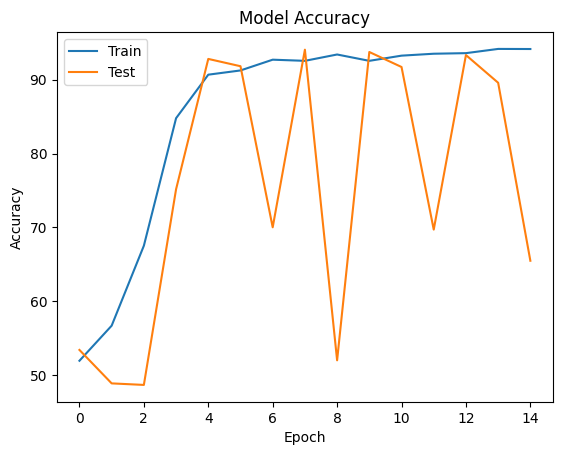

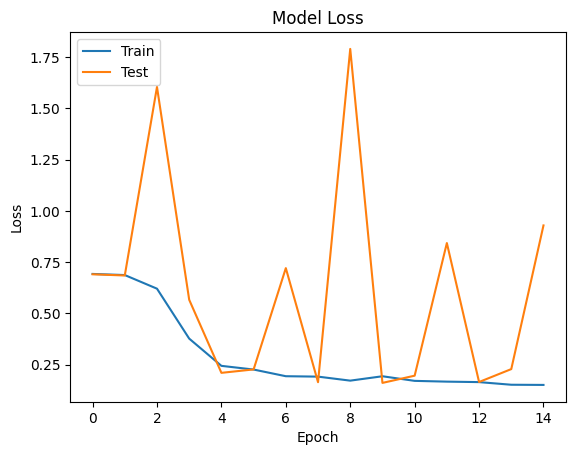

Words found are : 3304
Embedding(3304, 100)
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------


100%|██████████| 241/241 [00:09<00:00, 25.83it/s]


| Train Loss : 0.6920072823588385 |  Val Loss : 0.6904514701586102 | Train Acc : 52.23162078857422 | Val Acc : 50.65070343017578 |


100%|██████████| 241/241 [00:08<00:00, 27.76it/s]


| Train Loss : 0.6874627068047409 |  Val Loss : 0.6861603672401413 | Train Acc : 55.992191314697266 | Val Acc : 52.52472686767578 |


100%|██████████| 241/241 [00:09<00:00, 24.86it/s]


| Train Loss : 0.6464520909682294 |  Val Loss : 0.8246289322861527 | Train Acc : 65.7254409790039 | Val Acc : 51.2753791809082 |


100%|██████████| 241/241 [00:09<00:00, 25.01it/s]


| Train Loss : 0.4187999110758576 |  Val Loss : 0.25364743508224 | Train Acc : 81.92582702636719 | Val Acc : 89.17230224609375 |


100%|██████████| 241/241 [00:09<00:00, 25.04it/s]


| Train Loss : 0.2711645626035812 |  Val Loss : 0.22018889143465709 | Train Acc : 89.61613464355469 | Val Acc : 91.15044403076172 |


100%|██████████| 241/241 [00:09<00:00, 25.22it/s]


| Train Loss : 0.22691958760315517 |  Val Loss : 0.28564609468001667 | Train Acc : 91.2166519165039 | Val Acc : 88.755859375 |


100%|██████████| 241/241 [00:08<00:00, 27.74it/s]


| Train Loss : 0.2050375567137148 |  Val Loss : 0.16439110296984424 | Train Acc : 91.84124755859375 | Val Acc : 94.01353454589844 |


100%|██████████| 241/241 [00:09<00:00, 25.64it/s]


| Train Loss : 0.19596382613641028 |  Val Loss : 0.15669241009250026 | Train Acc : 92.54391479492188 | Val Acc : 93.64913940429688 |


100%|██████████| 241/241 [00:09<00:00, 25.06it/s]


| Train Loss : 0.18112539570480488 |  Val Loss : 0.18703588450454536 | Train Acc : 93.10344696044922 | Val Acc : 92.86830139160156 |


100%|██████████| 241/241 [00:09<00:00, 25.04it/s]


| Train Loss : 0.17685748666049833 |  Val Loss : 0.14519726240862973 | Train Acc : 93.1554946899414 | Val Acc : 94.16970825195312 |


100%|██████████| 241/241 [00:09<00:00, 24.32it/s]


| Train Loss : 0.1692535862617471 |  Val Loss : 0.1392941409911047 | Train Acc : 93.41574096679688 | Val Acc : 94.69026184082031 |


100%|██████████| 241/241 [00:09<00:00, 26.47it/s]


| Train Loss : 0.16545891745686142 |  Val Loss : 0.2595075731047413 | Train Acc : 93.50682830810547 | Val Acc : 87.81884002685547 |


100%|██████████| 241/241 [00:08<00:00, 27.26it/s]


| Train Loss : 0.16400604552856574 |  Val Loss : 0.1391465426215399 | Train Acc : 93.4417724609375 | Val Acc : 94.63821411132812 |


100%|██████████| 241/241 [00:09<00:00, 25.09it/s]


| Train Loss : 0.15776470711426877 |  Val Loss : 0.1510298492184286 | Train Acc : 93.68900299072266 | Val Acc : 93.7011947631836 |


100%|██████████| 241/241 [00:09<00:00, 25.04it/s]


| Train Loss : 0.15742482541416206 |  Val Loss : 0.14144895047546674 | Train Acc : 93.87117767333984 | Val Acc : 94.22175598144531 |


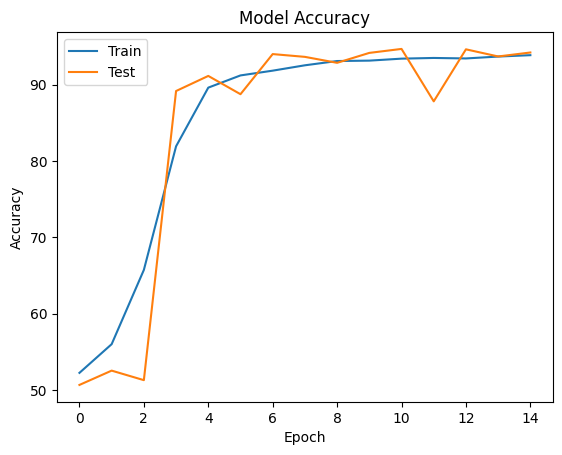

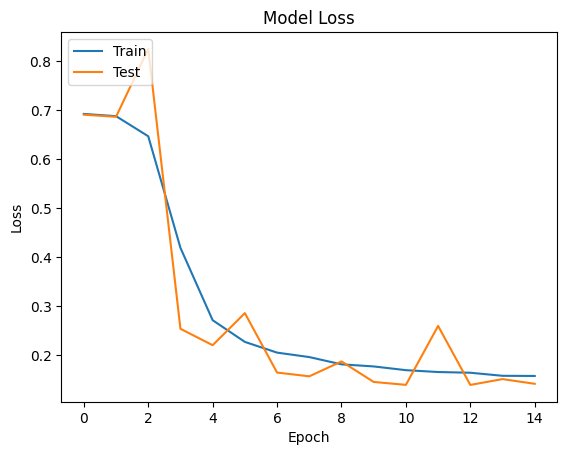

In [80]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# sfk = StratifiedKFold(n_splits = config.FOLDS)
kfold = KFold(n_splits = config.FOLDS)
model_state_dicts = {}

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = train_sampler, collate_fn = MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size = config.BATCH_SIZE, sampler = val_sampler, collate_fn = MyCollate(0, config.MAX_LEN))

    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab = VOCAB, emb_model = fasttext_model, trainable = False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)

#     model
#     model = Model(2, len(dataset.source_vocab), 128, 100, 1 ).to(config.DEVICE)
#     hidden = model.init_hidden(config.BATCH_SIZE)
#     model.hidden = hidden

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")
    for epoch in range(config.EPOCHS):
        train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_correct = val_epochs(val_loader, model, loss_fn)

        train_loss = train_loss/len(train_loader.sampler)
        val_loss = val_loss/len(val_loader.sampler)
        train_acc = (train_correct/len(train_loader.sampler))*100
        val_acc = (val_correct/len(val_loader.sampler))*100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu().numpy().tolist())
        val_accs.append(val_acc.cpu().numpy().tolist())

        print(f"| Train Loss : {train_loss} |", end = " ")
        print(f" Val Loss : {val_loss} |", end = " ")
        print(f"Train Acc : {train_acc} |", end = " ")
        print(f"Val Acc : {val_acc} |")


    # Saving the state dicts for the model
    model_state_dicts.update({f"LSTM-Model-for-{fold}" : model.state_dict(),
                             f"Model-Optimizer-for-{fold}" : optimizer.state_dict()})

#     # summarize history for accuracy
    plt.plot(train_accs)
    plt.plot(val_accs)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
#     # summarize history for loss
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [81]:
spath="/content/modelsave/"
torch.save(model_state_dicts, spath+"My-Model.pt")

In [82]:
def numericalize(text):

    numerialized_source = []
    numerialized_source = [dataset.source_vocab.stoi["<SOS>"]]
    numerialized_source += dataset.source_vocab.numericalize(text)
    numerialized_source.append(dataset.source_vocab.stoi["<EOS>"])

    return numerialized_source

def padding(source):
    padded_sequence = torch.zeros(config.MAX_LEN, 1, dtype = torch.int)
    source = torch.tensor(source)

    if len(source) > config.MAX_LEN:
        padded_sequence[:, 0] = source[: config.MAX_LEN]
    else:
        padded_sequence[:len(source), 0] = padded_sequence[:len(source), 0] + source

    return padded_sequence

def infer_processing(text):

    text = preprocessing(text)
    text = numericalize(text)
    text = padding(text)
    return text

def get_similarity(text, aspect):
    try:
        #text = " ".join(text)
        return fasttext_model.wv.n_similarity(text, aspect)
    except:
        return 0

def best_aspect(text, aspects):
    a = []

    for aspect in aspects:
        a.append(get_similarity(text, aspect))
    print(a,np.argmax(a))

    return aspects[np.argmax(a)]

In [83]:
aspects = ["phone", "camera", "battery", "neutral", "processor"]

In [84]:
sample = "I just love the phone , camera , features, bought for my mother and she absolutely love it thanks Flipkart."

ba = best_aspect(preprocessing(sample), aspects)
print(ba)

a = infer_processing(sample).to(config.DEVICE)

[0.8864643, 0.87776506, 0.9705988, 0.95533144, 0.9090449] 2
battery


In [85]:
model.eval()
sentiment = model(a)
sentiment = sentiment.cpu().detach().numpy()[0]
print(sentiment)

if sentiment > 0.5:
    sentiment = 'Positively'
else :
    sentiment = 'Negatively'

[0.9794453]


In [86]:
print(f"The reviewer is talking {sentiment} about the {ba} of the phone in his/her comment")

The reviewer is talking Positively about the battery of the phone in his/her comment
